#Theoretical model for a binary mixture of oppositely charged colloids with counterions and salt

###Required imports

---

In [65]:
import numdifftools as nd
from math import pi
from numpy import exp, log, sign
from numpy.linalg import det, slogdet, inv
from numpy import array, arange, linspace, append, matrix, dot, absolute
import matplotlib.pyplot as plt
import collections
import functools
import pickle
from scipy.fftpack import dst, idst
import timeit
%matplotlib inline 

###Create a memoized class to decorate some functions with and prevent trivial re-evaluation

---

In [66]:
class memoized(object):
    '''Decorator. Caches a function's return value each time it is called.
    If called later with the same arguments, the cached value is returned
    (not reevaluated).
    '''
    def __init__(self, func):
        self.func = func
        self.cache = {}
    def __call__(self, *args):
        if not isinstance(args, collections.Hashable):
            # uncacheable. a list, for instance.
            # better to not cache than blow up.
            return self.func(*args)
        if args in self.cache:
            return self.cache[args]
        else:
            value = self.func(*args)
            self.cache[args] = value
            return value
    def __repr__(self):
        '''Return the function's docstring.'''
        return self.func.__doc__
    def __get__(self, obj, objtype):
        '''Support instance methods.'''
        return functools.partial(self.__call__, obj)

###Function to create binary PY hardsphere RDFs using analytical results

The expressions are taken from http://dx.doi.org/10.1103/PhysRev.133.A895 (Eqns. 37 - 40)

---

In [67]:
#calculate the pressure
def calculate_pressure(p_1, p_2, d_1, d_2):
    eta_1 = (pi/6.0)*p_1
    eta_2 = (pi/6.0)*p_2
    xi = eta_1*(d_1**3.0) + eta_2*(d_2**3.0)
    
    P = ((p_1 + p_2)*(1.0 + xi + xi**2.0) - 
         (18.0/pi)*eta_1*eta_2*((d_2 - d_1)**2.0)*((d_1 + d_2) + d_1*d_2*(eta_1*(d_1**2.0) + eta_2*(d_2**2.0))))/((1.0 - xi)**3.0)
    
    return P


#numerically evaluate pressure derivatives
def calculate_pressure_derivs(p_1, p_2, d_1, d_2):
    deriv_steps = nd.MinStepGenerator(base_step=0.0001, step_ratio=2.0, num_steps = 4)
    
    P_1 = lambda x: calculate_pressure(x, p_2, d_1, d_2)
    P_2 = lambda x: calculate_pressure(p_1, x, d_1, d_2)
    dP_dp_1 = nd.Derivative(P_1, step = deriv_steps) 
    dP_dp_2 = nd.Derivative(P_2, step = deriv_steps)
    
    return (dP_dp_1(p_1).tolist(), dP_dp_2(p_2).tolist())


#generates the three PY direct correlation functions
#@memoized
def calculate_dcfs(p_1, p_2, d_1, d_2, N, dr):
    R = linspace(dr, N*dr, N)
    eta_1 = (pi/6.0)*p_1
    eta_2 = (pi/6.0)*p_2
    xi = eta_1*(d_1**3.0) + eta_2*(d_2**3.0)
    d_12 = (d_1 + d_2)/2.0
    dd_12 = (d_2 - d_1)/2.0
    
    g_11 = (1.0 + xi/2.0 + 3.0*eta_2*(d_2**2.0)*(d_1 - d_2)/2.0)/((1.0 - xi)**2.0)
    g_22 = (1.0 + xi/2.0 + 3.0*eta_1*(d_1**2.0)*(d_2 - d_1)/2.0)/((1.0 - xi)**2.0)
    g_12 = (d_2*g_11 + d_1*g_22)/(2.0*d_12)
    
    a_1, a_2 = calculate_pressure_derivs(p_1, p_2, d_1, d_2)
    
    b_1 = -6.0*(eta_1*(d_1**2.0)*(g_11**2.0) + eta_2*(d_12**2.0)*(g_12**2.0))
    b_2 = -6.0*(eta_2*(d_2**2.0)*(g_22**2.0) + eta_1*(d_12**2.0)*(g_12**2.0))
    
    b = -6.0*(eta_1*d_1*g_11 + eta_2*d_2*g_22)*d_12*g_12
    d = (eta_1*a_1 + eta_2*a_2)/2.0
    
    #load in the dcfs    
    #this is vectorized for maximum performance
    CR = {"c_11":array([]), "c_22":array([]), "c_12":array([])}   
        
    CR["c_11"] = (-a_1 - b_1*R - d*(R**3.0))*(R < d_1).astype(float)
    CR["c_22"] = (-a_2 - b_2*R - d*(R**3.0))*(R < d_2).astype(float)
    CR["c_12"] = ((-a_1)*(R <= dd_12).astype(float) 
                  + (-a_1 - (b*((R - dd_12)**2.0) + 4.0*dd_12*d*((R - dd_12)**3.0) 
                             + d*((R - dd_12)**4.0))/R)*(R > dd_12).astype(float)*(R < d_12).astype(float))
    
    return CR


#calculate the binary mixture rdfs
#this assumes that that particle 2 is larger than particle 1
@memoized
def calculate_rdfs(p_1, p_2, d_1, d_2, N, dr):
    r_max = N*dr
    k_min = pi*(0.5)/r_max
    k_max = pi*(float(N) - 0.5)/r_max
    K = linspace(k_min, k_max, N)
    R = linspace(dr, N*dr, N)
    ft_ind = linspace(1, N, N)
    
    CR = calculate_dcfs(p_1, p_2, d_1, d_2, N, dr)   
    
    CK = {}
    CK["c_11"] = ((4.0*pi*r_max**2.0)/(2.0*N**2.0))*dst(ft_ind*CR["c_11"], type=3)/K
    CK["c_22"] = ((4.0*pi*r_max**2.0)/(2.0*N**2.0))*dst(ft_ind*CR["c_22"], type=3)/K
    CK["c_12"] = ((4.0*pi*r_max**2.0)/(2.0*N**2.0))*dst(ft_ind*CR["c_12"], type=3)/K   
    
    HK = {"h_11":[], "h_22":[], "h_12":[]}
     
    mCK = matrix([[],[]])
    
    for i in range(len(K)):
        c_11 = CK["c_11"][i]
        c_22 = CK["c_22"][i]
        c_12 = CK["c_12"][i]
        
        ########################################################################
        
        mCK = matrix([[c_11, c_12],[c_12, c_22]])
        mI = matrix([[1.0, 0.0],[0.0, 1.0]])
        mP = matrix([[p_1, 0.0],[0.0, p_2]])
        
        mHK = dot(mCK, inv(mI - dot(mP, mCK)))
        
        HK["h_11"].append(mHK.item((0, 0)))
        HK["h_22"].append(mHK.item((1, 1)))
        HK["h_12"].append(mHK.item((0, 1)))
        
        ########################################################################
        
        #HK["h_11"].append(c_11)
        #HK["h_22"].append(c_22)
        #HK["h_12"].append(c_12)     
        
    core_loc_11 = int((d_1 - dr)/dr + 0.5)
    core_loc_22 = int((d_2 - dr)/dr + 0.5)
    core_loc_12 = int((0.5*(d_1 + d_2) - dr)/dr + 0.5)
    
    GR = {} 
    GR["g_11"] = (((4.0*pi*k_max**2.0)/((8.0*pi**3.0)*2.0*N**2.0))*idst(ft_ind*HK["h_11"], type=3)/R + 1.0)[core_loc_11 + 1:]
    GR["r_11"] = R[core_loc_11 + 1:]
    GR["g_22"] = (((4.0*pi*k_max**2.0)/((8.0*pi**3.0)*2.0*N**2.0))*idst(ft_ind*HK["h_22"], type=3)/R + 1.0)[core_loc_22 + 1:]
    GR["r_22"] = R[core_loc_22 + 1:]
    GR["g_12"] = (((4.0*pi*k_max**2.0)/((8.0*pi**3.0)*2.0*N**2.0))*idst(ft_ind*HK["h_12"], type=3)/R + 1.0)[core_loc_12 + 1:] 
    GR["r_12"] = R[core_loc_12 + 1:]

    return GR

In [69]:
#variables for transform
N = 16384/2/2/2
dr = 0.008

r_max = N*dr
k_min = pi*(0.5)/r_max
k_max = pi*(float(N) - 0.5)/r_max
K = linspace(k_min, k_max, N)
R = linspace(dr, N*dr, N)

p_1 = 1.0
p_2 = 1.0

d_1 = 0.2
d_2 = 1.000000001
CR = calculate_dcfs(p_1, p_2, d_1, d_2, N, dr)
GR = calculate_rdfs(p_1, p_2, d_1, d_2, N, dr)

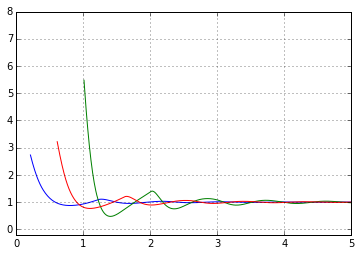

In [70]:
x1 = GR["r_11"]
x2 = GR["r_22"]
x3 = GR["r_12"]
y1 = GR["g_11"]
y2 = GR["g_22"]
y3 = GR["g_12"]

plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x3, y3)
plt.xlim([0, 5])
plt.ylim([-0.2, 8])
plt.grid()
plt.show()

##NOTE: All following free energy terms are per volume and thermal energy
####This makes the stability calculation easier by simplifying the form of the mixed partial derivatives needed for the stability calculation

##Variable definitions:
  * **d_c_1 & d_c_2** = colloid diameter
  * **p_c_1 & p_c_2** = colloid density
  * **Z_c_1 & Z_c_2** = colloid surface charge (positive or negative)
 
  
  * **p_pos** = positive monovalent salt or counterion density
  * **p_neg** = negative monovalent salt or counterion density

###Ideal free energy
---

In [71]:
def calculate_f_id(p_c_1, p_c_2, p_pos, p_neg, d_c_1, d_c_2):
    
    #just creating an arbitrary length scale to non-dimensionalize the log term
    vol = (d_c_1/2.0 + d_c_2/2.0)**3.0
    p = p_c_1 + p_c_2 + p_pos + p_neg
    
    #ideal contribution containing both mixing and translational entropy
    fid = p_c_1*log(p_c_1*vol) + p_c_2*log(p_c_2*vol) + p_pos*log(p_pos*vol) + p_neg*log(p_neg*vol) - p
    
    return fid

###Excess binary HS free energy

This uses the binary Carnahan Starling result of http://dx.doi.org/10.1063/1.1675048 (Eqn. 11)

---

In [72]:
def calculate_f_ex_hs(p_c_1, p_c_2, d_c_1, d_c_2):
    
    #for convenience i use a numbered notation similar to that in the above reference
    d1 = d_c_1
    d2 = d_c_2
    x1 = p_c_1/(p_c_1 + p_c_2)
    x2 = p_c_2/(p_c_1 + p_c_2)
    n1 = (pi/6.0)*p_c_1*(d_c_1**3.0)
    n2 = (pi/6.0)*p_c_2*(d_c_2**3.0)
    n = n1 + n2
    
    #calculate simplified values for free energy function
    q12 = (((n1*n2)**(1.0/2.0))/n)*(((d1 - d2)**2.0)/(d1*d2))*((x1*x2)**(1.0/2.0))
    y1 = q12*(d1 + d2)*((d1*d2)**(-1.0/2.0))
    y2 = (q12/n)*((d1*d2)**(1.0/2.0))*(n1/d1 + n2/d2)
    y3 = (((n1/n)**(2.0/3.0))*(x1**(1.0/3.0)) + ((n2/n)**(2.0/3.0))*(x2**(1.0/3.0)))**3.0
    
    #final binary hs free energy
    f_ex_hs = (p_c_1 + p_c_2)*(-(3.0/2.0)*(1.0 - y1 + y2 + y3) 
                                    + (3.0*y2 + 2.0*y3)/(1.0 - n) 
                                    + (3.0/2.0)*(1.0 - y1 - y2 - (1.0/3.0)*y3)/((1.0 - n)**2.0) 
                                    + (y3 - 1.0)*log(1.0 - n))
    
    return f_ex_hs

###Perturbative polyion-polyion DLVO free energy

This uses the DLVO theory http://dx.doi.org/10.1103/PhysRevE.59.2010 (Eqn. 61 - 65)

Also used is the Mayer function perturbation expansion of http://dx.doi.org/10.1080/00268970701416605 (Eqn. 9 and 15)

---

In [73]:
def calculate_cc_perturb_integrals(p_c_1, p_c_2, #state variables (removed p_p)
                        k, #redundant state variables already calculated in calling function
                        l, Z_c_1, Z_c_2, d_c_1, d_c_2, #system parameters
                        N, dr): # integration parameters
    
    #effective charge parameter to be used in calculating the DLVO colloid-colloid pair interaction
    Z_c_1_eff = Z_c_1*(exp(k*(d_c_1/2.0))/(1.0 + k*(d_c_1/2.0)))
    Z_c_2_eff = Z_c_2*(exp(k*(d_c_2/2.0))/(1.0 + k*(d_c_2/2.0)))
    
    #use a bare HS fluid (colloid) + ideal point particle (polymer) system as the reference 
    GR = calculate_rdfs(p_c_1, p_c_2, d_c_1, d_c_2, N, dr)
    
    #calculate the three integrals
    #the rdf only contains data outside the core region
    #NOTE: for better performance i vectorized the trapezoidal integration, so no explicit loops
    
    #1-1 calculation
    GR_I = GR["g_11"][0:-1]
    GR_II = GR["g_11"][1:]
    R_I = GR["r_11"][0:-1]
    R_II = GR["r_11"][1:]
    BUR_I = (Z_c_1_eff**2.0)*l*(exp(-k*R_I)/R_I)
    BUR_II = (Z_c_1_eff**2.0)*l*(exp(-k*R_II)/R_II)
    FR_I = exp(-BUR_I) - 1.0
    FR_II = exp(-BUR_II) - 1.0
    integral_11 = 0.5*dr*sum(R_I*R_I*GR_I*FR_I + R_II*R_II*GR_II*FR_II)
    
    #2-2 calculation
    GR_I = GR["g_22"][0:-1]
    GR_II = GR["g_22"][1:]
    R_I = GR["r_22"][0:-1]
    R_II = GR["r_22"][1:]
    BUR_I = (Z_c_2_eff**2.0)*l*(exp(-k*R_I)/R_I)
    BUR_II = (Z_c_2_eff**2.0)*l*(exp(-k*R_II)/R_II)
    FR_I = exp(-BUR_I) - 1.0
    FR_II = exp(-BUR_II) - 1.0
    integral_22 = 0.5*dr*sum(R_I*R_I*GR_I*FR_I + R_II*R_II*GR_II*FR_II)
    
    #1-2 calculation
    GR_I = GR["g_12"][0:-1]
    GR_II = GR["g_12"][1:]
    R_I = GR["r_12"][0:-1]
    R_II = GR["r_12"][1:]
    BUR_I = (Z_c_1_eff*Z_c_2_eff)*l*(exp(-k*R_I)/R_I)
    BUR_II = (Z_c_1_eff*Z_c_2_eff)*l*(exp(-k*R_II)/R_II)
    FR_I = exp(-BUR_I) - 1.0
    FR_II = exp(-BUR_II) - 1.0
    integral_12 = 0.5*dr*sum(R_I*R_I*GR_I*FR_I + R_II*R_II*GR_II*FR_II)
        
    return (integral_11, integral_22, integral_12)

#############################################################################################

@memoized
def calculate_f_ex_dlvo(p_c_1, p_c_2, p_pos, p_neg, #state variables
                        l, Z_c_1, Z_c_2, d_c_1, d_c_2, #system parameters
                        N, dr): #integration parameters
    
    #calculate various other parameters that make the below expression a little cleaner
    #ion variables
    p_ions = p_pos + p_neg
    s = (2.0*p_pos*p_neg)/p_ions
    k = (4.0*pi*l*p_ions)**(1.0/2.0)
    #colloid variables
    n_c_1 = (pi/6.0)*p_c_1*(d_c_1**3.0)
    n_c_2 = (pi/6.0)*p_c_2*(d_c_2**3.0)
    n_c = n_c_1 + n_c_2
        
    #breaking up the various contributions for simplicity
    #NOTE: for safety i use integers for the exponents when charges are present to ensure sign preservation
    f_ex_dlvo_ion_coord = -((p_c_1*(Z_c_1**2)*(l/d_c_1))*((k*(d_c_1/2.0))/(1.0 + k*(d_c_1/2.0)))
                           + (p_c_2*(Z_c_2**2)*(l/d_c_2))*((k*(d_c_2/2.0))/(1.0 + k*(d_c_2/2.0))))
    f_ex_dlvo_exc_vol = (n_c*s)/(1.0 - n_c)
    f_ex_dlvo_neg_mean_field = -(1.0/2.0)*((4.0*pi*l*((p_c_1*Z_c_1)**2))/(k**2.0)
                                           + (4.0*pi*l*((p_c_2*Z_c_2)**2))/(k**2.0)
                                           + 2.0*(4.0*pi*l*(p_c_1*Z_c_1*p_c_2*Z_c_2))/(k**2.0))
    #calculate perturbation integrals
    (c1_c1_perturb_integral, 
     c2_c2_perturb_integral, 
     c1_c2_perturb_integral) = calculate_cc_perturb_integrals(p_c_1, p_c_2, k, l, Z_c_1, Z_c_2, d_c_1, d_c_2, N, dr)
    
    #calculate the mean field dlvo pair contribution us binary hard sphere reference structure
    #NOTE: the negative in front of the 1/2 is because i am using a MAYER FUNCTION perturbation expansion
    f_ex_dlvo_pair_perturb = -(1.0/2.0)*(4.0*pi*(p_c_1**2.0)*c1_c1_perturb_integral
                                           + 4.0*pi*(p_c_2**2.0)*c2_c2_perturb_integral
                                           + 2.0*4.0*pi*(p_c_1*p_c_2)*c1_c2_perturb_integral)
    
    #total DLVO contribution to the free energy
    f_ex_dlvo = f_ex_dlvo_ion_coord + f_ex_dlvo_exc_vol + f_ex_dlvo_neg_mean_field + f_ex_dlvo_pair_perturb
    
    return f_ex_dlvo

In [74]:
#variables for transform
N = 16384/2
dr = 0.002

p_c_1 = 12.0 #0.6
p_c_2 = 0.6 #0.1

p_pos = 0.1
p_neg = 0.1

Z_c_1 = -10.0
Z_c_2 = 10.0

l = 0.2364

d_c_1 = 0.2
d_c_2 = 1.000000001

calculate_f_ex_dlvo(p_c_1, p_c_2, p_pos, p_neg, l, Z_c_1, Z_c_2, d_c_1, d_c_2, N, dr)


-313584783639.64514

In [ ]:
-26.654992398174279

###Calculates the total free energy of the colloid-polymer-ion system
This just calls the four separate free energy functions and adds them all up. 

Up to this point I have treated the colloid and ions all as separate entities. Formally this is fine but electroneutrality ultimately sets a linear constraint on what combinations of the three charges species are possible.

---

In [75]:
def calculate_f_explicit_ions(p_c_1, p_c_2, p_pos, p_neg, #state variables
                              d_c_1, d_c_2, #particle sizes
                              l, Z_c_1, Z_c_2, #ionic solution parameters
                              N, dr #integration parameters
                             ):
    
    #ideal
    f_id = calculate_f_id(p_c_1, p_c_2, p_pos, p_neg, d_c_1, d_c_2)
    #excess hs
    f_ex_hs = calculate_f_ex_hs(p_c_1, p_c_2, d_c_1, d_c_2)
    #excess perturbative dlvo
    f_ex_dlvo = calculate_f_ex_dlvo(p_c_1, p_c_2, p_pos, p_neg, l, Z_c_1, Z_c_2, d_c_1, d_c_2, N, dr) 
    #the whole thing
    f = f_id + f_ex_hs + f_ex_dlvo
    
    return f

This is an alternative form that expresses the free energy in terms of densities alone by simply referencing the other form--this makes the stability calculation easier to work with.

In [77]:
def calculate_f(p_c_1, p_c_2, p_s, #state variables
                d_c_1, d_c_2, #particle sizes
                l, Z_c_1, Z_c_2, #ionic solution parameters
                N, dr #integration parameters
               ):
        
    #calculate the various densities based on specifying the salt density and the colloid and polymer
    p_pos = float(Z_c_1 <= 0.0)*(p_c_1*abs(Z_c_1)) + float(Z_c_2 <= 0.0)*(p_c_2*abs(Z_c_2)) + p_s
    p_neg = float(Z_c_1 > 0.0)*(p_c_1*abs(Z_c_1)) + float(Z_c_2 > 0.0)*(p_c_2*abs(Z_c_2)) + p_s
        
    #sum up the contributions
    f = calculate_f_explicit_ions(p_c_1, p_c_2, p_pos, p_neg, d_c_1, d_c_2, l, Z_c_1, Z_c_2, N, dr)

    return (f, f/(p_c_1 + p_c_2 + p_pos + p_neg))

###Function for calculating the stability matrix and its determinant
This calculates the determinant of the 3x3 stability matrix for use in finding homogenous phase spinodal limits. The matrix is only 3x3 despite the 4 components due to charge neutrality. The particular choice I make for the matrix is the 3x3 of chemical potential derivatives with respect to the colloid, polymer and salt particle numbers. Also, the **free energy is per V** (not N) as this simplifies the matrix elements.

---

In [78]:
def calculate_stability_determinant(p_c_1, p_c_2, p_s, #state variables
                                    d_c_1, d_c_2, #particle sizes
                                    l, Z_c_1, Z_c_2, #ionic solution parameters
                                    N, dr, #integration parameters
                                    min_step #minimum step to use for hessian calculation
                                   ):
    
    #calculate the hessian matrix
    hess_steps = nd.MinStepGenerator(base_step=min_step, step_ratio=2.0, num_steps = 2)
    calculate_hessian = lambda x: calculate_f(x[0], x[1], x[2], d_c_1, d_c_2, l, Z_c_1, Z_c_2, N, dr)[0]
    stability_matrix = nd.Hessian(calculate_hessian, step = hess_steps)([p_c_1, p_c_2, p_s])
    
    #build the 3x3 stability matrix as a numpy array and calculate the determinant 
    #logdet is used to avoid issues with a small determinant (such as when an instability is reached)
    (sign, logdet) = slogdet(stability_matrix)
    stability_determinant = sign*exp(logdet)    
        
    #return the stability determinant
    return (stability_matrix, stability_determinant)

**Test to see if stability calculation is even working**

In [112]:
#set variables
N = 16384/2/2
dr = 0.004

d_c_1 = 1.0 #0.2
d_c_2 = 1.0

n_c_1 = 0.01
n_c_2 = 0.01
p_s = 0.01

l = 0.2364
Z_c_1 = 0.001#30.0
Z_c_2 = 0.001#-30.0

min_step = 0.002

#alternatives
p_c_1 = 6.0*n_c_1/(pi*d_c_1**3.0)
p_c_2 = 6.0*n_c_2/(pi*d_c_2**3.0)

print calculate_f(p_c_1, p_c_2, p_s, d_c_1, d_c_2, l, Z_c_1, Z_c_2, N, dr)
print calculate_stability_determinant(p_c_1, p_c_2, p_s, d_c_1, d_c_2, l, Z_c_1, Z_c_2, N, dr, min_step)

(-0.29832774355031888, -5.1227917715154616)
(array([[  56.85455262,    4.52510972,    0.64471122],
       [   4.52510972,   56.85455262,    0.64471122],
       [   0.64471122,    0.64471122,  197.24536105]]), 633501.40550835384)


In [ ]:
(9472.9822436520772, 0.9990576909568385)
(9472.9822436520772, 0.9990576909568385)

###Spinodal calculation from stability matrix
This is a grid search that identifies points as being stable or unstable. Both types are passed back in separate arrays that can be plotted together to get a coarse grained view of the underlying phase behavior.

---

In [115]:
#performs grid search and labels each point as stable or unstable
def calculate_spinodal(p_c_1_low, p_c_1_hi, p_c_1_inc, p_c_2_low, p_c_2_hi, p_c_2_inc, #state variables for grid search
                    p_s, #state variables held fixed
                    d_c_1, d_c_2, #particle sizes
                    l, Z_c_1, Z_c_2, #ionic solution parameters 
                    N, dr, #integration parameters
                    min_step #minimum step to use for hessian calculation
                    ):
    
    #lists for storing the grid points classified as stable and unstable 
    stable = [[],[],[],[],[]]
    unstable = [[],[],[],[],[]]
    
    #sample the grid points
    p_c_1 = p_c_1_low
    while p_c_1 < p_c_1_hi:
        print p_c_1
        p_c_2 = p_c_2_low
        while p_c_2 < p_c_2_hi:
            determinant = calculate_stability_determinant(p_c_1, p_c_2, p_s, d_c_1, d_c_2, l, Z_c_1, Z_c_2, N, dr, min_step)[1]
            if determinant < 0.0:
                unstable[0].append(p_c_1)
                unstable[1].append(p_c_2)
                unstable[2].append(p_c_1/p_c_2)
                unstable[3].append(((pi/6.0)*d_c_1**3.0)*p_c_1)
                unstable[4].append(((pi/6.0)*d_c_2**3.0)*p_c_2)
            else:
                stable[0].append(p_c_1)
                stable[1].append(p_c_2)
                stable[2].append(p_c_1/p_c_2)
                stable[3].append(((pi/6.0)*d_c_1**3.0)*p_c_1)
                stable[4].append(((pi/6.0)*d_c_2**3.0)*p_c_2)
            p_c_2 = p_c_2 + p_c_2_inc
            #print p_p
        p_c_1 = p_c_1 + p_c_1_inc
        #print p_c
    
    return (stable, unstable)

In [59]:
#explicitly finds the spinodal boundary only
def calculate_spinodal_boundary_density(p_c_low, p_c_hi, p_c_inc, p_p_low, p_p_hi, p_p_inc, #state variables for grid search
                    p_s, #state variables held fixed
                    d_c, d_p, #particle sizes
                    l, Z_c, #ionic solution parameters 
                    R_cp, BA, #interfacial attraction parameters
                    min_step #minimum step to use for hessian calculation
                    ):
    
    #list for storing the boundary
    boundary = [[],[],[],[],[]]
    
    #sample the grid points
    p_p = p_p_low
    while p_p < p_p_hi:
        p_c = p_c_low
        determinant_previous = 0.0001
        boundary_count = 0 
        while (p_c < p_c_hi) and (boundary_count < 2):
            determinant = calculate_stability_determinant(p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA, min_step)[1]   
            if ((determinant < 0.0) and (determinant_previous > 0.0)) or ((determinant > 0.0) and (determinant_previous < 0.0)):
                slope = (determinant - determinant_previous)/p_c_inc
                intercept = determinant - slope*p_c
                p_c_spinodal = -intercept/slope
                boundary[0].append(p_c_spinodal)
                boundary[1].append(p_p)
                boundary[2].append(p_p/p_c_spinodal)
                boundary[3].append(((pi/6.0)*d_c*d_c*d_c)*p_c_spinodal)
                boundary[4].append(((pi/6.0)*d_p*d_p*d_p)*p_p)
                boundary_count = boundary_count + 1
            p_c = p_c + p_c_inc
            determinant_previous = determinant
        p_p = p_p + p_p_inc       
        
    #sort from smallest to largest
    zipped_list = zip(boundary[0][:], boundary[1][:], boundary[2][:], boundary[3][:], boundary[4][:])
    boundary[0], boundary[1], boundary[2], boundary[3], boundary[4] = zip(*sorted(zipped_list[:]))
    
    return boundary

In [67]:
#explicitly finds the spinodal boundary only
def calculate_spinodal_boundary_ratio(p_c_low, p_c_hi, p_c_inc, g_pc_low, g_pc_hi, g_pc_inc, #state variables for grid search
                    p_s, #state variables held fixed
                    d_c, d_p, #particle sizes
                    l, Z_c, #ionic solution parameters 
                    R_cp, BA, #interfacial attraction parameters
                    min_step #minimum step to use for hessian calculation
                    ):
    
    #list for storing the boundary
    boundary = [[],[],[],[],[]]
    
    #sample the grid points
    g_pc = g_pc_low
    while g_pc < g_pc_hi:
        #get initial point manualy
        p_c = p_c_low
        p_p = g_pc * p_c 
        determinant_previous = calculate_stability_determinant(p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA, min_step)[1]
        #move on next point
        p_c = p_c_low + p_c_inc
        boundary_count = 0 
        while (p_c < p_c_hi) and (boundary_count < 2):
            p_p = g_pc * p_c 
            determinant = calculate_stability_determinant(p_c, p_p, p_s, d_c, d_p, l, Z_c, R_cp, BA, min_step)[1]
            if ((determinant < 0.0) and (determinant_previous > 0.0)) or ((determinant > 0.0) and (determinant_previous < 0.0)):
                slope = (determinant - determinant_previous)/p_c_inc
                intercept = determinant - slope*p_c
                p_c_spinodal = -intercept/slope
                p_p_spinodal = g_pc*p_c_spinodal
                boundary[0].append(p_c_spinodal)
                boundary[1].append(p_p_spinodal)
                boundary[2].append(p_p_spinodal/p_c_spinodal)
                boundary[3].append(((pi/6.0)*d_c*d_c*d_c)*p_c_spinodal)
                boundary[4].append(((pi/6.0)*d_p*d_p*d_p)*p_p_spinodal)
                boundary_count = boundary_count + 1
            p_c = p_c + p_c_inc
            determinant_previous = determinant
        g_pc = g_pc + g_pc_inc       
        
    #sort from smallest to largest
    zipped_list = zip(boundary[0][:], boundary[1][:], boundary[2][:], boundary[3][:], boundary[4][:])
    boundary[0], boundary[1], boundary[2], boundary[3], boundary[4] = zip(*sorted(zipped_list[:]))
    
    return boundary

**Set parameters and calculate the phase diagram**

In [139]:
#actual experimental parameters (with dimensions of nm)
#d_c_exp = 6.6
#d_p_exp = 2.2
#l_exp = 1.56

#parameters
d_c_1 = 0.999999999
d_c_2 = 1.000000001
N = 16384/2/2/2/2
dr = 0.016
l = 0.2364
Z_c_1 = -5.0
Z_c_2 = 5.0

#colloid
n_c_1_low = 0.005 #0.015
n_c_1_hi = 0.12
n_c_1_inc = 0.005 #0.015
#polymer
n_c_2_low = 0.005 #0.015
n_c_2_hi = 0.12
n_c_2_inc = 0.005 #0.015

#recalculate in terms of densities
p_c_1_low = 6.0*n_c_1_low/(pi*d_c_1**3.0)
p_c_1_hi = 6.0*n_c_1_hi/(pi*d_c_1**3.0)
p_c_1_inc = 6.0*n_c_1_inc/(pi*d_c_1**3.0)
p_c_2_low = 6.0*n_c_2_low/(pi*d_c_2**3.0)
p_c_2_hi = 6.0*n_c_2_hi/(pi*d_c_2**3.0)
p_c_2_inc = 6.0*n_c_2_inc/(pi*d_c_2**3.0)

#salt
p_s = 0.0001

min_step= 0.001 #0.001
stable, unstable = calculate_spinodal(p_c_1_low, p_c_1_hi, p_c_1_inc, 
                                      p_c_2_low, p_c_2_hi, p_c_2_inc, 
                                      p_s, d_c_1, d_c_2, l, Z_c_1, Z_c_2, N, dr, min_step)

0.00954929661416
0.0190985932283
0.0286478898425
0.0381971864566
0.0477464830708
0.057295779685
0.0668450762991
0.0763943729133
0.0859436695275
0.0954929661416
0.105042262756
0.11459155937
0.124140855984
0.133690152598
0.143239449212
0.152788745827
0.162338042441
0.171887339055
0.181436635669
0.190985932283
0.200535228897
0.210084525512
0.219633822126
0.22918311874


**Plot the phase diagram**

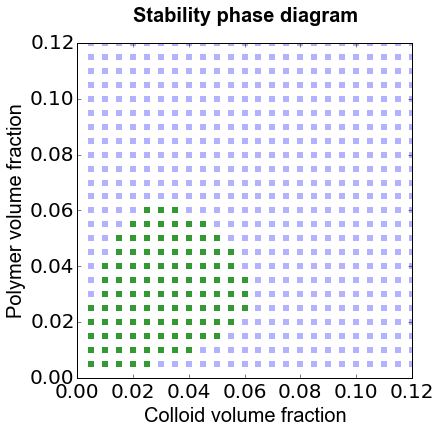

In [140]:
#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


plt.xlabel('Colloid volume fraction', fontsize=20, fontdict = axis_label_font)
plt.ylabel('Polymer volume fraction', fontsize=20, fontdict = axis_label_font)
plt.scatter(stable[3], stable[4], c="b", marker="s", s=40, alpha=0.3, linewidths=0.0)
plt.scatter(unstable[3],unstable[4], c="g", marker="s", s=40, alpha=0.8, linewidths=0.0)
plt.ylim((0,0.12))
plt.xlim((0,0.12))

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title("Stability phase diagram", y=1.05, fontdict = title_font)


###Extra functions

---

---

---

**Sizes**

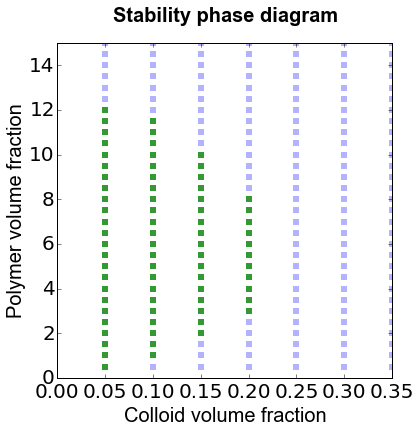

In [36]:
#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


plt.xlabel('Colloid volume fraction', fontsize=20, fontdict = axis_label_font)
plt.ylabel('Polymer volume fraction', fontsize=20, fontdict = axis_label_font)
plt.scatter(stable[3], stable[1], c="b", marker="s", s=40, alpha=0.3, linewidths=0.0)
plt.scatter(unstable[3],unstable[1], c="g", marker="s", s=40, alpha=0.8, linewidths=0.0)
plt.ylim((0,15))
plt.xlim((0,0.35))

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title("Stability phase diagram", y=1.05, fontdict = title_font)

In [15]:
import numpy as np
sum([n*proba[n] for n in range(7)])

1.800000051898494

###Check of free energy using monodisperse hs

In [ ]:
def calculate_f_ex_hs_mono(p, d_c):
    
    #for convenience I just us a numbered notation similar to that in the above reference
    n = (pi/6.0)*p*(d_c**3.0)
    
    #final binary hs free energy
    f_ex_hs_mono = p*((4.0*n - 3.0*(n**2.0))/((1.0 - n)**2.0))
    
    return f_ex_hs_mono

In [129]:
p_c_pos = 0.2
p_c_neg = 0.3
p = p_c_pos + p_c_neg

d_c = 1.2
d_c_pos = d_c
d_c_neg = d_c

print calculate_f_ex_hs(p_c_pos, p_c_neg, d_c_pos, d_c_neg)
print calculate_f_ex_hs_mono(p, d_c)

1.99346280814
1.99346280814
